# Health Insurance Cross-Sell Prediction
This dataset will be used to predict whether customers with a health insurance policy with a company would also be willing to buy a vehicle insurance policy.
Reference: (Kaggle) <br>
https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [1]:
#Import all necessary modules
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import scipy.stats as sc
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
import category_encoders as ce
from sklearn.metrics import plot_roc_curve
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy import stats

In [2]:
# Read in the training & test datasets obtained from Kaggle
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
#train.shape,test.shape
df = pd.read_csv('train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [4]:
#Check first few rows
#train['is_train'] = 1
#test['is_train'] = 0
#df = pd.concat([train,test])
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Most variables are categorical except age, vintage and annual premium

In [5]:
#Drop id column
df.drop('id',inplace=True,axis=1)

In [6]:
df.shape

(381109, 11)

In [7]:
#Check for null values (No null values in this dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


In [8]:
df.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

0    87.743664
1    12.256336
Name: Response, dtype: float64


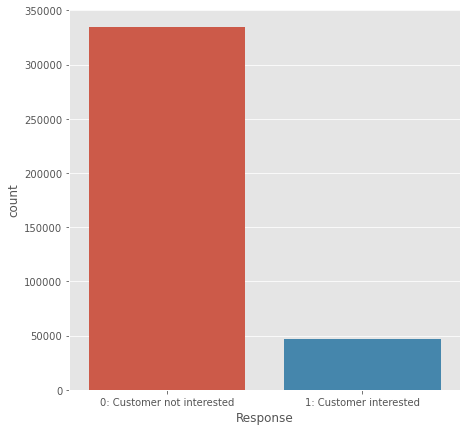

In [9]:
#Check responses for willing/unwilling to buy a vehicle insurance policy
print((df['Response'].value_counts(normalize=True)*100))
plt.figure(figsize=[7,7])
ax = sns.countplot(x='Response',data=df);
ax.set_xticklabels(['0: Customer not interested','1: Customer interested']);

This is an imbalanced class problem, with 13% of the people in the training dataset interested in the vehicle insurance policy

In [10]:
df[['Age','Vintage','Annual_Premium']].describe()

,Age,Vintage,Annual_Premium
count,381109.000000,381109.000000,381109.000000
mean,38.822584,154.347397,30564.389581
std,15.511611,83.671304,17213.155057
min,20.000000,10.000000,2630.000000
25%,25.000000,82.000000,24405.000000
50%,36.000000,154.000000,31669.000000
75%,49.000000,227.000000,39400.000000
max,85.000000,299.000000,540165.000000


Min Age: 20 Max Age: 85


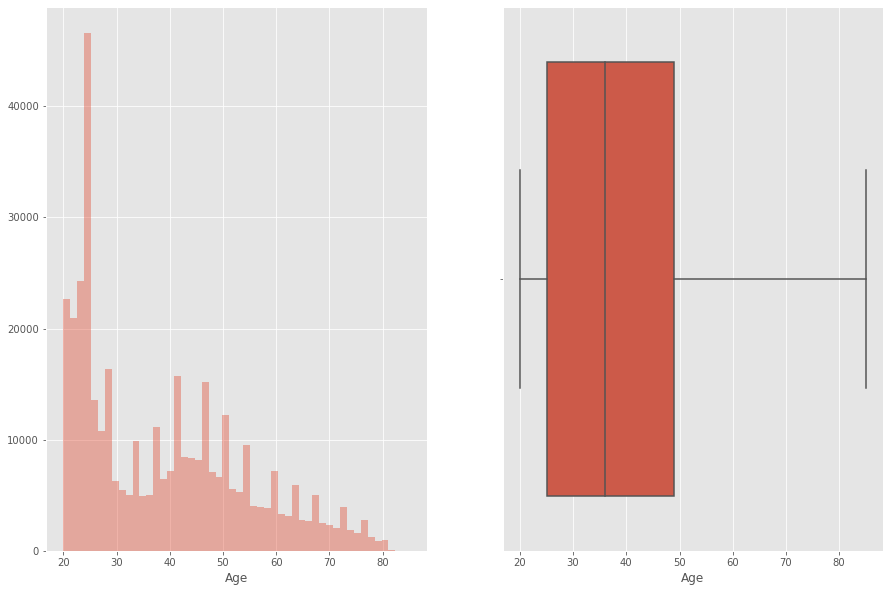

In [11]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=[15,10])
sns.distplot(df['Age'],kde=False, ax= ax[0])
sns.boxplot(df['Age'])
print('Min Age:',np.min(df['Age']),'Max Age:',np.max(df['Age']))

Age exhibits a right skewed distribution. Next, bin ages in buckets of 10 years and compare against response.

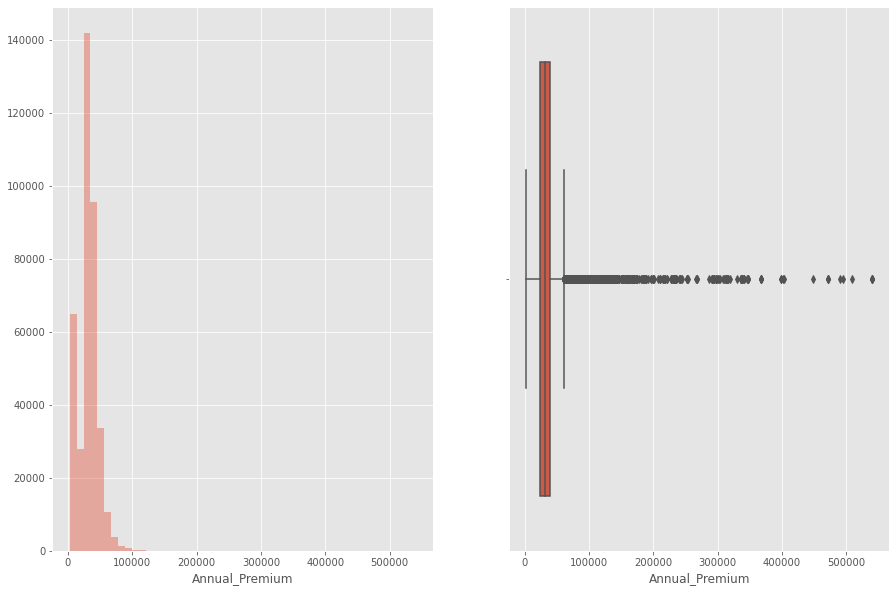

In [12]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=[15,10])
sns.distplot(df['Annual_Premium'],kde=False, ax= ax[0])
sns.boxplot(df['Annual_Premium'])

Annual premium also shows a right skewed distribution with some outliers

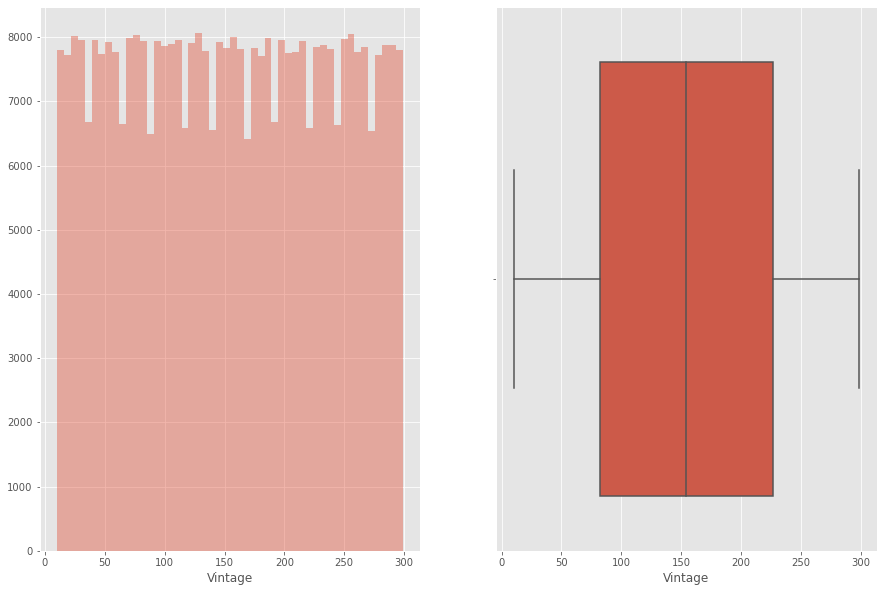

In [13]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=[15,10])
sns.distplot(df['Vintage'],kde=False, ax= ax[0])
sns.boxplot(df['Vintage'])

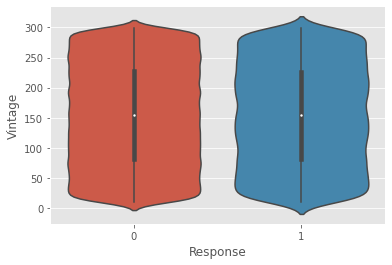

In [14]:
sns.violinplot(x=df['Response'],y=df['Vintage'],data=df)

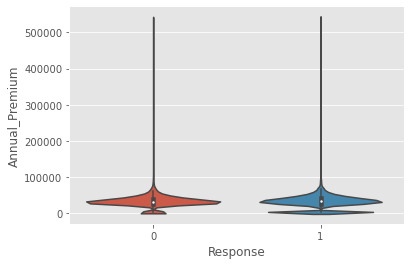

In [15]:
sns.violinplot(x=df['Response'],y=df['Annual_Premium'],data=df)

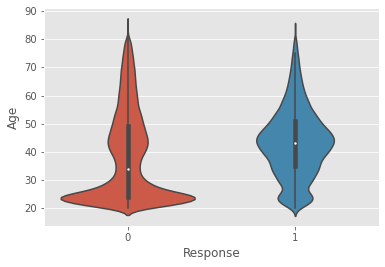

In [16]:
sns.violinplot(x=df['Response'],y=df['Age'],data=df)

In [17]:
#Bin ages into groups
df['Age_bins'] = pd.cut(df['Age'],bins=[10,20,30,40,50,60,70,80,90])

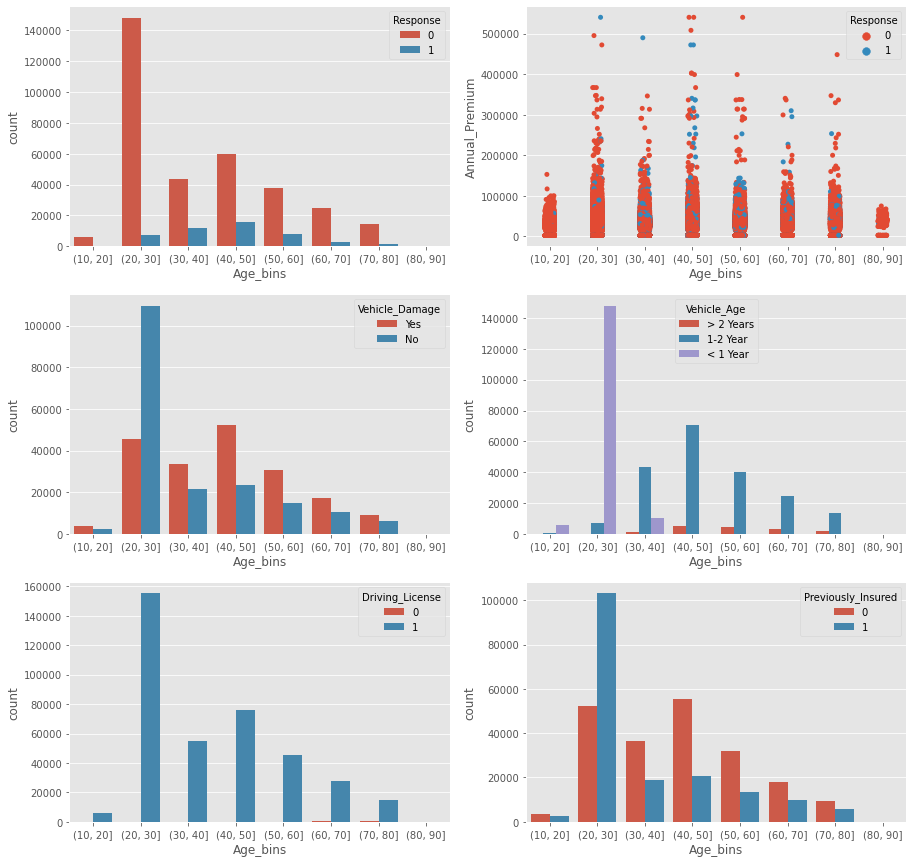

In [18]:
f,ax = plt.subplots(3,2,figsize=(15,15))
sns.countplot(df['Age_bins'],hue=df['Response'],ax=ax[0][0])
sns.stripplot(x='Age_bins',y='Annual_Premium',hue='Response',data=df,ax=ax[0][1])
sns.countplot('Age_bins',hue='Vehicle_Damage',data=df,ax=ax[1][0])
sns.countplot(df['Age_bins'],hue=df['Vehicle_Age'],ax=ax[1][1])
sns.countplot(df['Age_bins'],hue=df['Driving_License'],ax=ax[2][0])
sns.countplot('Age_bins',hue='Previously_Insured',data=df,ax=ax[2][1])

Ages show a right tailed distribution. Dividing into bins, it is observed that the highest respondents are in the age group 20-30 and most are not interested in a vehicle insurance policy.<br> Age group 40-50 age showed the most interest in a vehicle insurance policy
<br>Most premiums are within 100,000-200,000 with a few outliers as seen. Age groups 20-30 appear to be paying slightly higher premiums. Next, check the spread of premium among various groups
<br>Except age group 20-30, all others show the count of 'yes' higher than no vehicle damage. Age group 20-30 is a major component of this dataset and has the highest count for no vehicle damage
<br>Age groups 20-30 shows a majority ownership of vehicles <1 years while most others show 1-2 years
<br>Most people have a driving license with a negligible amount not having one not detected in the count plot.
<br>Vintage shows an equal distribution of people in all age groups

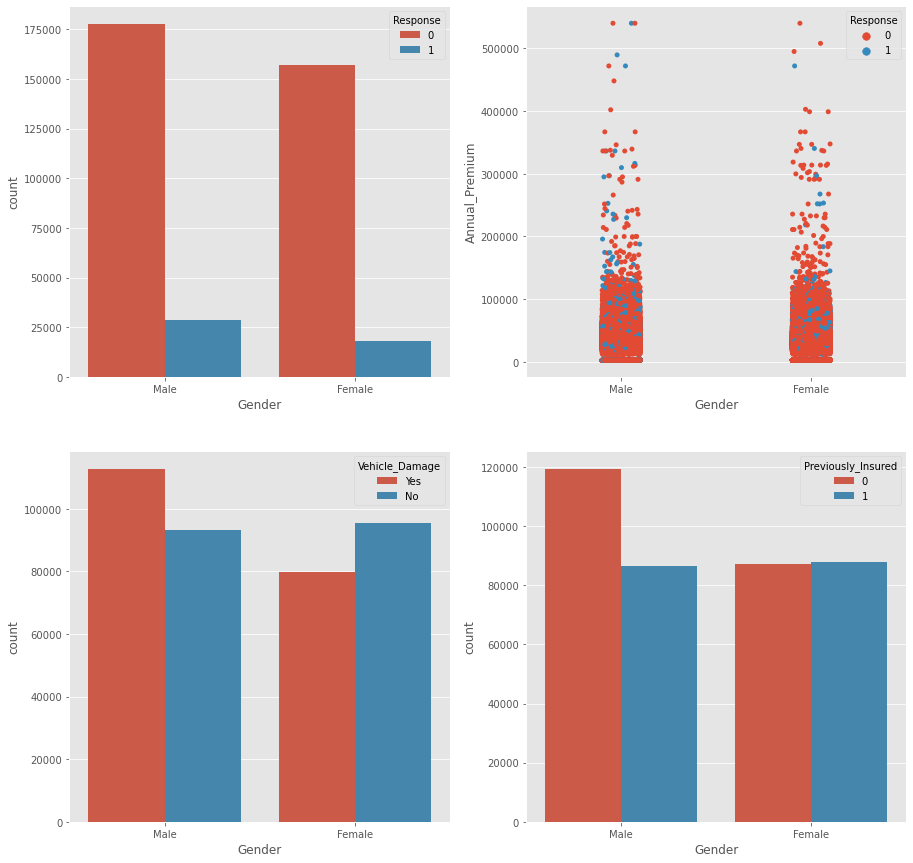

In [19]:
f,ax = plt.subplots(2,2,figsize=(15,15))
sns.countplot('Gender',hue='Response',data=df,ax=ax[0][0])
sns.stripplot(x='Gender',y='Annual_Premium',hue='Response',data=df,ax=ax[0][1])
sns.countplot(x='Gender',hue='Vehicle_Damage',data=df,ax=ax[1][0])
sns.countplot('Gender',hue='Previously_Insured',data=df,ax=ax[1][1])

Marginally, more men seem to be interested in an auto insurance policy. Annual premiums do not show any noticable difference across genders.
Higher number of vehicle damages vs no damages for men compared to women

In [20]:
#Frequencies of driving license and final responses
pd.pivot_table(df,index='Response',columns=['Driving_License'],aggfunc='size')

Driving_License,0,1
Response,,
0,771,333628
1,41,46669


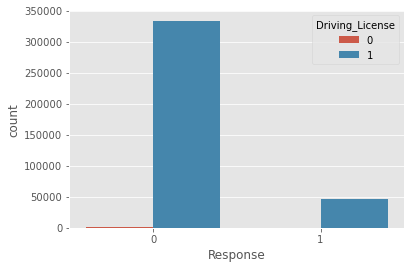

In [21]:
sns.countplot(x='Response',hue='Driving_License',data=df);

In [22]:
#Frequencies of previously insured and final responses
pd.pivot_table(df,index='Response',columns=['Previously_Insured'],aggfunc='size')

Previously_Insured,0,1
Response,,
0,159929,174470
1,46552,158


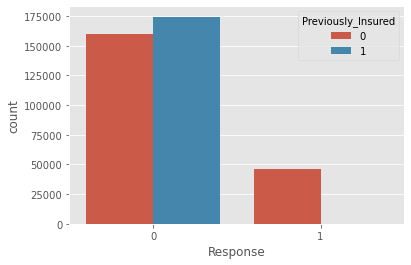

In [23]:
sns.countplot(x='Response',hue='Previously_Insured',data=df);

Most people who are interested in the vehicle insurance policy were not insured previously. Fairly equal split between customers who were/were not insured and not interested in a vehicle insurance policy

In [24]:
#Frequencies of vehicle damage and final responses
pd.pivot_table(df,index='Response',columns=['Vehicle_Damage'],aggfunc='size')

Vehicle_Damage,No,Yes
Response,,
0,187714,146685
1,982,45728


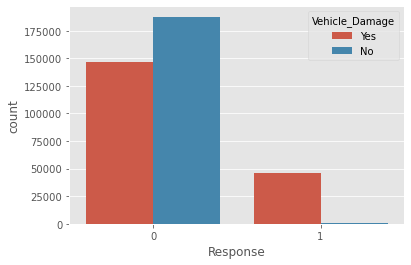

In [25]:
sns.countplot(x='Response',hue='Vehicle_Damage',data=df);

Most people interested in a vehicle insurance policy reported vehicle damage. For those not interested, ~41,000 more people did not have vehicle damage

In [26]:
#Frequencies of vehicle age and final responses
pd.pivot_table(df,index='Response',columns=['Vehicle_Age'],aggfunc='size')

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years
Response,,,
0,165510,157584,11305
1,34806,7202,4702


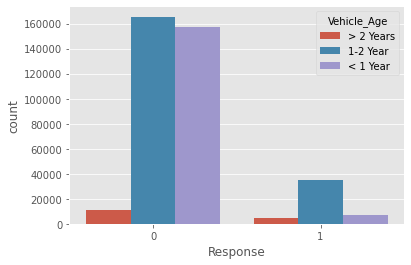

In [27]:
sns.countplot(x='Response',hue='Vehicle_Age',data=df);

Most people who indicated an interest for vehicle insurance have their vehicle age between 1-2 years

In [28]:
df.dtypes

Gender                    object
Age                        int64
Driving_License            int64
Region_Code              float64
Previously_Insured         int64
Vehicle_Age               object
Vehicle_Damage            object
Annual_Premium           float64
Policy_Sales_Channel     float64
Vintage                    int64
Response                   int64
Age_bins                category
dtype: object

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
122.0      9930
157.0      6684
154.0      5993
151.0      3885
163.0      2893
Name: Policy_Sales_Channel, dtype: int64


155

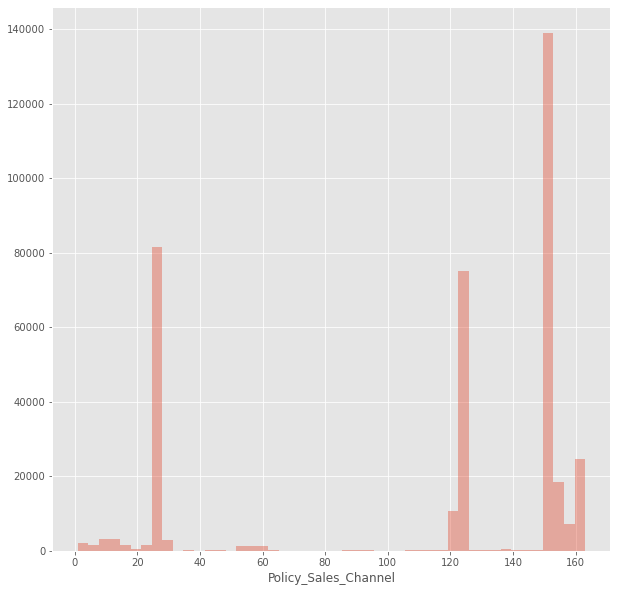

In [29]:
plt.figure(figsize=[10,10])
sns.distplot(df['Policy_Sales_Channel'],kde=False)
print(df['Policy_Sales_Channel'].value_counts(ascending=False).nlargest(10))
len(df['Policy_Sales_Channel'].unique())

There are a large number of sales channels (155) out of which 152 shows the largest count, followed by 26,124 and 160

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
Name: Region_Code, dtype: int64


53

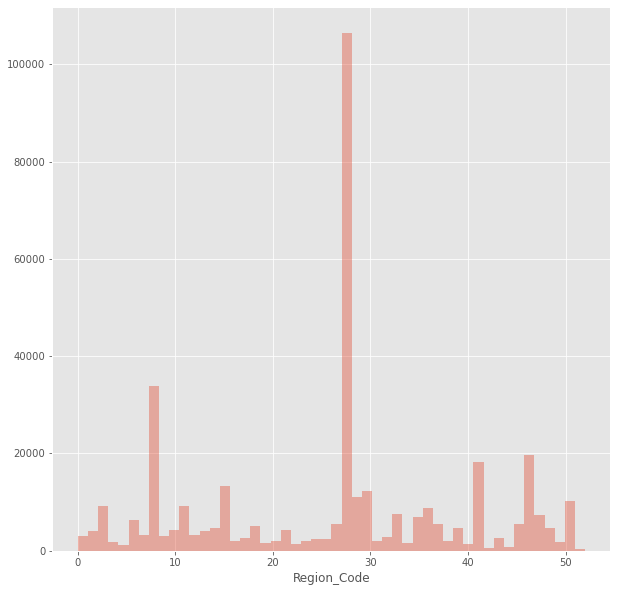

In [30]:
plt.figure(figsize=[10,10])
sns.distplot(df['Region_Code'],kde=False)
print(df['Region_Code'].value_counts(ascending=False).nlargest(10))
len(df['Region_Code'].unique())

Same as policy sales channel, there are many region codes (55) with codes 28 and 8 being most prevalent.

In [31]:
t6_channels = pd.DataFrame(df['Policy_Sales_Channel'].value_counts().nlargest(6)).reset_index()['index'].tolist()
t6_regcodes = pd.DataFrame(df['Region_Code'].value_counts().nlargest(6)).reset_index()['index'].tolist()
df_ch = df.loc[df['Policy_Sales_Channel'].isin(t6_channels)]
df_re = df.loc[df['Region_Code'].isin(t6_regcodes)]

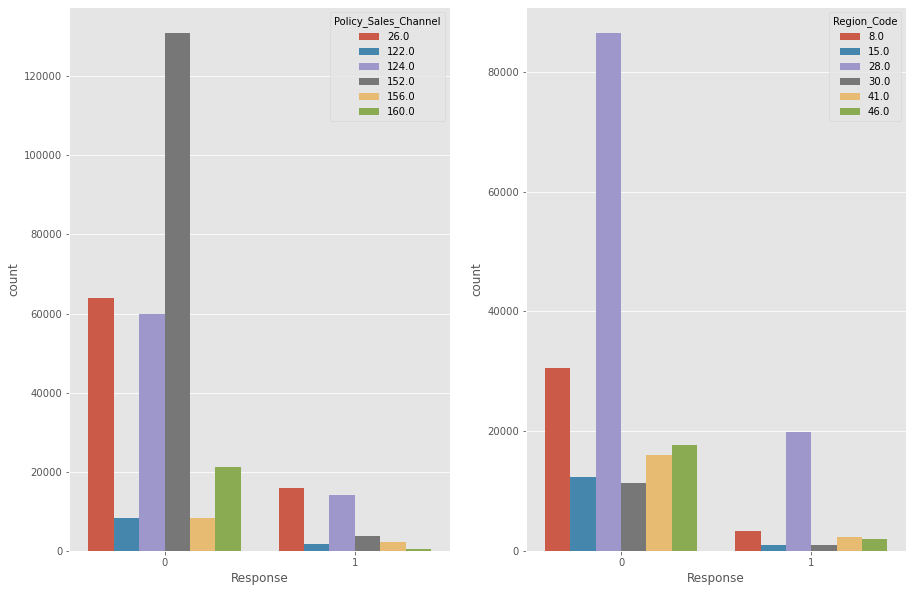

In [32]:
f,ax = plt.subplots(1,2,figsize=[15,10])
sns.countplot(x='Response',hue='Policy_Sales_Channel',data=df_ch,ax=ax[0]);
sns.countplot(x='Response',hue='Region_Code',data=df_re,ax=ax[1]);

In [33]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_bins
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,"(40, 50]"
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,"(70, 80]"
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,"(40, 50]"
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,"(20, 30]"
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,"(20, 30]"


Weight of Evidence is used to encode all categorical features. This helps in addressing the problem of high dimensionality that may be introduced with one hot encoding. It is based on a log odds formula for the target variable and does not increase the feature space
<br>Particularly, Region_Code and Policy_Sales_Channel have high cardinality and thus would have created a large feature space which would be sparse when using one-hot encoding

In [34]:
#df = df.drop(['Annual_Premium','Vintage'],axis=1)
#df.dtypes

In [35]:
#Apply log transformation to Age and Annual Premium.
df['Age_log'] = (df['Age']).transform(np.log)
df['Annual_Premium_log'] = (df['Annual_Premium']).transform(np.log)
#df = df.drop(['Age','Annual_Premium'],axis=1)

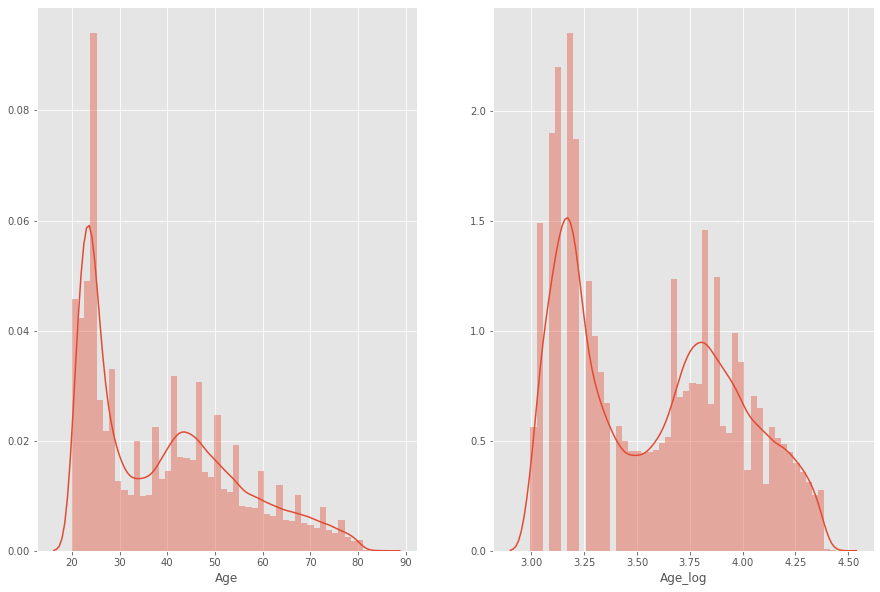

In [36]:
f,ax = plt.subplots(1,2,figsize=[15,10])
sns.distplot(df['Age'],ax=ax[0])
sns.distplot(df['Age_log'],ax=ax[1])

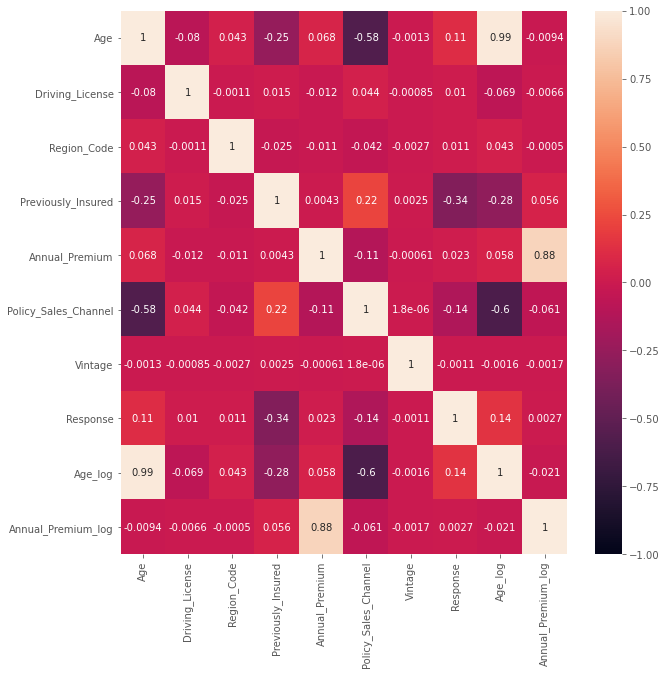

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=+1)

In [38]:
#xcols = [a for a in df.columns if a not in ['Age','Annual_Premium','Response']]
#train = df[df['is_train']==1]
#test = df[df['is_train']==0]
#X_train = train.drop(['is_train','Response'],axis=1)
#X_test = test.drop(['is_train','Response'],axis=1)
#y_train = train['Response']
#y_test = test['Response']
# xcols = [a for a in df.columns if a not in ['Age','Annual_Premium','Response']]
# X = df[xcols]
# y = df['Response']

In [39]:
# catf = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured','Vehicle_Age', 'Vehicle_Damage',
#             'Policy_Sales_Channel']
# X_train = X_train.copy()
# X_test = X_test.copy()
# # X_train[catf] = X_train[catf].astype(str)
# X_test[catf] = X_test[catf].astype(str)
# woe = ce.WOEEncoder(cols=catf)
# woe.fit(X_train[catf],y_train)
# X_train[catf] = woe.transform(X_train[catf],y_train).add_suffix('_te')
# X_test[catf] = woe.transform(X_test[catf],y_test).add_suffix('_te')
# #X_test_woe = pd.concat([X_test,(woe.transform(X_test,y_test).add_suffix('_te'))],axis=1)
# #X_train = X_train.drop(catf,axis=1)
# X_train = X_train.drop(['Age_bins'],axis=1)
# #X_test = X_test.drop(catf,axis=1)
# X_test = X_test.drop(['Age_bins'],axis=1)

In [40]:
#Categorical Variable Encoder
def cat_encode(X_train,X_test,y_train,y_test):
    catf = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured','Vehicle_Age', 'Vehicle_Damage',
            'Policy_Sales_Channel']
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train[catf] = X_train[catf].astype(str)
    X_test[catf] = X_test[catf].astype(str)
    woe = ce.WOEEncoder(cols=catf)
    woe.fit(X_train[catf],y_train)
    X_train[catf] = woe.transform(X_train[catf],y_train).add_suffix('_te')
    X_test[catf] = woe.transform(X_test[catf],y_test).add_suffix('_te')
    #X_train = X_train.drop(['Age_bins'],axis=1)
    #X_test = X_test.drop(['Age_bins'],axis=1)
    return X_train, X_test, y_train, y_test

#Data Scaler
def scale(X_train,X_test,y_train,y_test):
    cols = X_train.columns
    sl = StandardScaler()
    sl.fit(X_train)
    X_train = pd.DataFrame(sl.transform(X_train),columns = cols).add_suffix('_scaled')
    X_test = pd.DataFrame(sl.transform(X_test),columns = cols).add_suffix('_scaled')
    return X_train, X_test, y_train, y_test

#PCA Feature Selection
def PCA_train(X_train,X_test,n_components):
    #PCA on the scaled training set
    pca=PCA(n_components=len(X_train.columns))
    pca.fit(X_train)
    var = pca.explained_variance_
    cm_evr = np.cumsum(pca.explained_variance_ratio_)
    f,ax = plt.subplots(1,2,figsize=[15,8])
    sns.lineplot(x=range(len(var)),y=var,ax=ax[0])
    sns.lineplot(x=range(len(cm_evr)),y=cm_evr,ax=ax[1])
    plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
    plt.xlabel('Principal Components',fontsize=17)
    plt.ylabel('Explained Variance',fontsize=15);
    sns.set(font_scale=1)
    pca = PCA(n_components=n_components)
    pca_cols = ['pca_'+str(a) for a in range(n_components)]
    pca.fit(X_train)
    X_train = pd.DataFrame(pca.transform(X_train),columns=pca_cols)
    X_test = pd.DataFrame(pca.transform(X_test),columns=pca_cols)
    return X_train, X_test

#Resampling Data
def resample_train(X_train,y_train,undersample=False,smote=False,smote_str =0.3,undersample_str=0.6):
    #Resampling techniques
    print('Pre-resampling ',Counter(y_train))
    if smote == True:
        sm = SMOTE(random_state=1,sampling_strategy=smote_str)
        #sm = SMOTE(random_state=1)
        X_train,y_train = sm.fit_resample(X_train,y_train)
        print('Oversampling (SMOTE) Class 1 = {}X Class 0 '.format(smote_str),Counter(y_train))
    #ros = RandomOverSampler()
    #X_tr_ros, y_tr_ros = ros.fit_resample(X_train,y_train)
    if undersample == True:
        rus = RandomUnderSampler(sampling_strategy=undersample_str)
        X_train, y_train = rus.fit_resample(X_train,y_train)
        print('Undersampling Class 0 for Class 1 = {}X Class 0'.format(undersample_str),Counter(y_train))
#     if smotetomek == True:
#         print('Combining SMOTE and Tomek links...')
#         smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
#         X_train, y_train = smt.fit_resample(X_train,y_train)
#         print('Combining SMOTE, TOMEK links, removing the majority class with Tomek links = {}'.format(Counter(y_train)))
    return X_train, y_train

In [41]:
#Model
def model(model,X_train, X_test, y_train, y_test,feat_importance=True):
    mod.fit(X_train,y_train)
    y_tr_pred = mod.predict(X_train)
    y_tr_pred_prob = mod.predict_proba(X_train)
    y_te_pred = mod.predict(X_test)
    y_te_pred_prob = mod.predict_proba(X_test)
    if feat_importance == True:
        imp = pd.Series(mod.feature_importances_,X_train.columns).sort_values(ascending=True)
        imp.plot(kind='barh',title='Feature_Importance',figsize=(8,6),fontsize=12)
    #depth = [estimator.get_depth() for estimator in mod.estimators_]
    #print('Max Depth: ',max(depth))
    return y_tr_pred, y_tr_pred_prob,y_te_pred,y_te_pred_prob

In [42]:
# Classifier Results
def model_metrics(y_true,y_predicted,y_pred_prob):
    sns.heatmap(confusion_matrix(y_true,y_predicted),annot=True,fmt='g',cmap="Blues")
    plt.xlabel('Predicted Classes')
    plt.ylabel('Observed Classes')
    print('ROC_AUC Score: ' + str(roc_auc_score(y_true,y_pred_prob[:,1])))
    print('Accuracy_Score: ' + str(accuracy_score(y_true,y_predicted)))
    print('Precision_Score: ' + str(precision_score(y_true,y_predicted)))
    print('F1 Score: ' + str(f1_score(y_true,y_predicted)))
    print('Classification Report: ' + str(classification_report(y_true,y_predicted)))
    
# ROC / Precision Recall Curves
def roc_prerec(y_true,y_pred_prob):
    fpr, tpr, th = roc_curve(y_true,y_pred_prob[:,1])
    plt.figure(figsize=[10,10])
    plt.plot(fpr, tpr, linestyle='-.', label='Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    pre, re, the = precision_recall_curve(y_true,y_pred_prob[:,1])
    plt.figure(figsize=[10,10])
    plt.plot(re, pre, linestyle='-.', label='Random Forest')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend()

In [43]:
#Preprocessing
xcols = [a for a in df.columns if a not in ['Age','Annual_Premium','Response','Age_bins']]
X = df[xcols]
y = df['Response']
#Split data into test and train components
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
Counter(y_train)

#Encode Categorical Data
X_train, X_test, y_train, y_test = cat_encode(X_train,X_test,y_train,y_test)

#Scale Data
X_train, X_test, y_train, y_test = scale(X_train,X_test,y_train,y_test)

#PCA Feature Selection
#X_train, X_test = PCA_train(X_train,X_test,n_components=6)

#Resampling for balancing classes
X_train,y_train = resample_train(X_train,y_train,undersample=True,smote=True,smote_str =0.3,undersample_str=0.6)
#X_train.info()

Pre-resampling  Counter({0: 267519, 1: 37368})
Oversampling (SMOTE) Class 1 = 0.3X Class 0  Counter({0: 267519, 1: 80255})
Undersampling Class 0 for Class 1 = 0.6X Class 0 Counter({0: 133758, 1: 80255})


In [44]:
print(Counter(y_train))

Counter({0: 133758, 1: 80255})


In [45]:
X_train.head()

,Gender_scaled,Driving_License_scaled,Region_Code_scaled,Previously_Insured_scaled,Vehicle_Age_scaled,Vehicle_Damage_scaled,Policy_Sales_Channel_scaled,Vintage_scaled,Age_log_scaled,Annual_Premium_log_scaled
0,-1.083423,0.046258,-0.478819,0.919430,-1.129851,-1.010203,-1.106183,-0.792607,-0.462417,0.120917
1,0.923001,0.046258,-0.596765,-1.087631,-1.129851,-1.010203,-1.106183,1.263200,-0.828696,-0.082997
2,-1.083423,0.046258,1.322566,0.919430,0.794912,0.989900,0.893794,-0.589417,-1.500241,0.226548
3,0.923001,0.046258,-1.369295,-1.087631,0.794912,-1.010203,-1.013568,-0.637226,0.074382,0.398051
4,0.923001,0.046258,0.165294,-1.087631,0.794912,-1.010203,-1.106183,-0.434036,-0.142050,-2.128546


In [110]:
#Fit Model
#mod = RandomForestClassifier(n_estimators= 400,verbose=10,max_depth=30,min_samples_leaf=2,min_samples_split=2,oob_score=True)
mod = GradientBoostingClassifier(verbose=11,n_estimators=350,min_samples_split=1100,min_samples_leaf=400,subsample=0.7,learning_rate=0.05)
#mod = AdaBoostClassifier()
#n_estimators=300,verbose=10,learning_rate=0.05
#mod = DecisionTreeClassifier(max_depth=10)
#mod = LogisticRegression()
#mod = XGBClassifier(n_estimators=1000,silent=0)
#mod = LGBMClassifier()
#mod = CatBoostClassifier()
y_tr_pred, y_tr_pred_prob,y_te_pred,y_te_pred_prob = model(mod,X_train, X_test, y_train, y_test,feat_importance=False)

ROC_AUC Score: 0.8468604735879226
Accuracy_Score: 0.831557817952822
Precision_Score: 0.3520852719736063
F1 Score: 0.39332797807494213
Classification Report:               precision    recall  f1-score   support

           0       0.92      0.89      0.90     66880
           1       0.35      0.45      0.39      9342

    accuracy                           0.83     76222
   macro avg       0.64      0.67      0.65     76222
weighted avg       0.85      0.83      0.84     76222



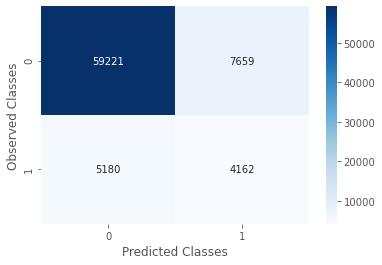

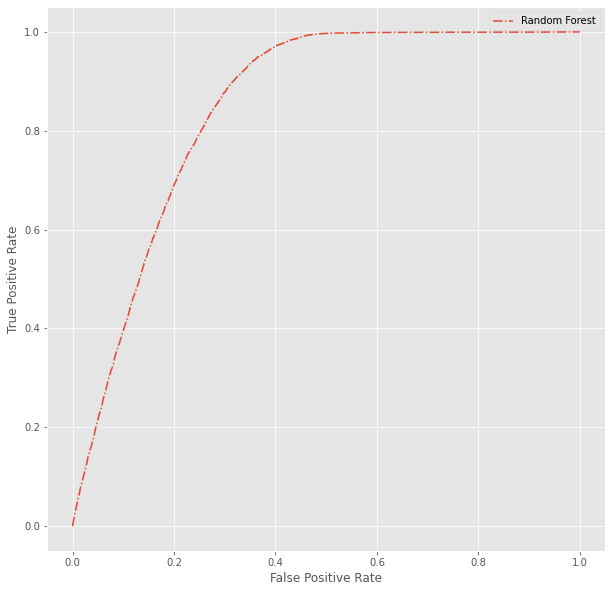

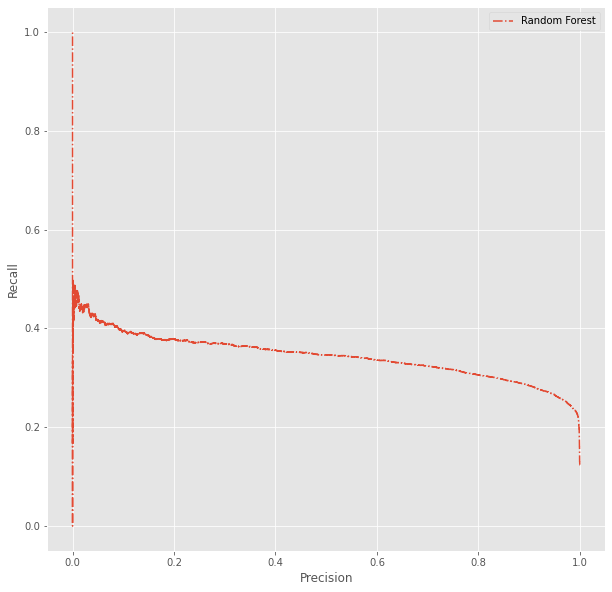

In [111]:
#Model Results
model_metrics(y_test,y_te_pred,y_te_pred_prob)
roc_prerec(y_test,y_te_pred_prob)

In [87]:
# # #GridSearchCV with Gradient Boost
# params = {'n_estimators':[200,300,450], 'max_depth':[1,3,5],'min_samples_leaf':range(40,400,50),
#           'min_samples_split':range(100,1000,200),'subsample':[0.6,0.9]}
# gb = GradientBoostingClassifier()
# skf = StratifiedKFold(n_splits=3)
# grid_cv = GridSearchCV(gb,param_grid = params,scoring='f1',n_jobs=-1,cv=skf,verbose=12)
# model = grid_cv.fit(X_train,y_train)
# model.grid_scores_, model.best_params_, model.best_score_
# print("tuned hpyerparameters :(best parameters) ",model.best_params_)
# print("precision :",model.best_score_)

In [ ]:
# #Randomized Search with Random Forest
# params = {'bootstrap':[True,False],
#           'n_estimators':[200,300,500,1000],
#           'max_depth':[10,20,30,40],
#           'min_samples_leaf':[1,2,4],
#           'min_samples_split':[2,5,10],
#           'max_features':['sqrt','log2']}
# rf = RandomForestClassifier()
# random_cv = RandomizedSearchCV(estimator=rf,params=params,cv=3,n_iter=20,n_jobs=-1,verbose=5)

In [48]:
# #GridSearchCV with Random Forest 
# params = {'n_estimators':[200,400,600,800], 'max_depth':[15,30,50],'min_samples_leaf':[2,4],
#           'min_samples_split':[2,4]}
# rf = RandomForestClassifier(oob_score=True)
# grid_cv = GridSearchCV(rf,param_grid = params,scoring='precision',n_jobs=-1,cv=3,verbose=12)
# model = grid_cv.fit(X_train,y_train)
# print("tuned hpyerparameters :(best parameters) ",model.best_params_)
# print("precision :",model.best_score_)

In [ ]:
rf_grid_results = pd.DataFrame(model.cv_results_)
rf_grid_results.head()

In [ ]:
y_tr_pred = model.predict(X_train)
y_tr_pred_prob = model.predict_proba(X_train)
y_te_pred = model.predict(X_test)
y_te_pred_prob = model.predict_proba(X_test)
model_metrics(y_test,y_te_pred,y_te_pred_prob)
roc_prerec(y_test,y_te_pred_prob)

In [ ]:
#Categorical Variable Encoder
# def cat_encode(X_train,X_test,y_train,y_test):
#     catf = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured','Vehicle_Age', 'Vehicle_Damage',
#             'Policy_Sales_Channel','Age_bins_lbl']
#     #catf = ['Gender', 'Driving_License', 'Previously_Insured','Vehicle_Age', 'Vehicle_Damage']
#     X_train[catf] = X_train[catf].astype(str)
#     X_test[catf] = X_test[catf].astype(str)
#     woe = ce.WOEEncoder(cols=catf)
#     woe.fit(X_train,y_train)
#     X_train = pd.concat([X_train,(woe.transform(X_train,y_train).add_suffix('_te'))],axis=1)
#     X_test = pd.concat([X_test,(woe.transform(X_test,y_test).add_suffix('_te'))],axis=1)
#     X_train = X_train.drop(catf,axis=1)
#     #X_train = X_train.drop(['Age_bins'],axis=1)
#     X_test = X_test.drop(catf,axis=1)
#     #X_test = X_test.drop(['Age_bins'],axis=1)
#     return X_train, X_test, y_train, y_test